# **Результат**

Параметры модели - 997.611

Эпох - 4

Оптимизатор - Adam

Loss функция - SparseCategoricalCrossentropy

Аугментация - Х5

train loss - 0.1432

train accuracy - 0.9478 

val loss - 0.573

val accuracy - 0.833

# **Библиотеки**

In [ ]:
!pip install opencv-python==4.4.0.42

     |████████████████████████████████| 49.4MB 60kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from google.colab import drive
import imgaug.augmenters as iaa
import tarfile
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
drive.mount('/content/drive')

Mounted at /content/drive


Распаковываем файлы с google диска

In [ ]:
tar = tarfile.open("drive/MyDrive/ds_TD.tar")
tar.extractall()
tar.close()

# **Нормировка и аугментация**

Аугментация (Х5).
Отдельно для каждого изображения

In [ ]:
def aug_images(img):
    augs = []
    img_s = []
    augs.append(iaa.AverageBlur(k=5))  # Размыть изображение
    augs.append(iaa.Fliplr(0.5))  # Отразить изображение
    augs.append(iaa.Flipud(0.5))
    augs.append(iaa.Sequential([
        iaa.Flipud(0.5),
        iaa.Fliplr(0.5)
        ]))
    for i in range(len(augs)):
        img_s.append(augs[i].augment_images(img))
    return img_s

Нормировка изображения по ширене и высоте (параметр - dsize)

In [ ]:
def norm_img(path, dsize):
    for label in range(3):
        for root, dirs, files in os.walk(f"{path}{label + 1}/"):  
            for filename in files:
                img = cv2.imread(f'{path}{label + 1}/{filename}')
                img = cv2.resize(img, dsize)
                cv2.imwrite(f'{path}{label + 1}/{filename}', img) # Сохранение отнормированного оригинала
                copies_img = aug_images(img) # Аугментация
                for count in range(len(copies_img)): # Сохранение копий
                    cv2.imwrite(f'{path}{label + 1}/{count}_{filename}', copies_img[count])

In [ ]:
train_dir = 'ds TD/train/'
valid_dir = 'ds TD/valid/'
dsize = (400, 400)
norm_img(valid_dir, dsize)
norm_img(train_dir, dsize)

/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/meta.py:553: UserWarning: You provided a numpy array of shape (400, 400, 3) as input to augment_images(), which was interpreted as (N, H, W). The last dimension however has value 1 or 3, which indicates that you provided a single image with shape (H, W, C) instead. If that is the case, you should use augment_image(image) or augment_images([image]), otherwise you will not get the expected augmentations.
  "you will not get the expected augmentations." % (images_copy.shape,))


# **Dataset**

Создание датасетов для трайна и валидации

In [ ]:
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=1,
  image_size=dsize,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=1,
  image_size=dsize,
  batch_size=batch_size)

Found 158855 files belonging to 3 classes.
Found 14965 files belonging to 3 classes.


Масштабирование пикселей

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# **Model**

In [ ]:
num_classes = 3

model = tf.keras.Sequential([
                                                    
  tf.keras.layers.Conv2D(24, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(24, 24, activation='relu'),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),


  tf.keras.layers.Conv2D(24, 24, activation='relu'),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(24, 24, activation='relu'),
  tf.keras.layers.BatchNormalization(axis=-1),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Обучение модели

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=4
)
model.summary()

Epoch 1/4
2483/2483 [==============================] - 1678s 648ms/step - loss: 0.4761 - accuracy: 0.8128 - val_loss: 0.6605 - val_accuracy: 0.7681
Epoch 2/4
2483/2483 [==============================] - 1608s 646ms/step - loss: 0.2617 - accuracy: 0.9045 - val_loss: 0.5663 - val_accuracy: 0.8088
Epoch 3/4
2483/2483 [==============================] - 1615s 649ms/step - loss: 0.1856 - accuracy: 0.9327 - val_loss: 0.5724 - val_accuracy: 0.8244
Epoch 4/4
2483/2483 [==============================] - 1618s 651ms/step - loss: 0.1432 - accuracy: 0.9478 - val_loss: 0.5730 - val_accuracy: 0.8330
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 398, 398, 24)      672       
_________________________________________________________________
batch_normalization (BatchNo (None, 398, 398, 24)      96        
__________________________________________________________

Графики

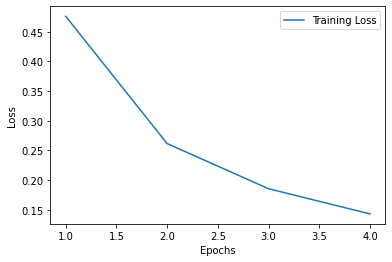

In [ ]:
loss_train = history.history['loss']
epochs = range(1, len(loss_train)+1)

plt.plot(epochs, loss_train, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

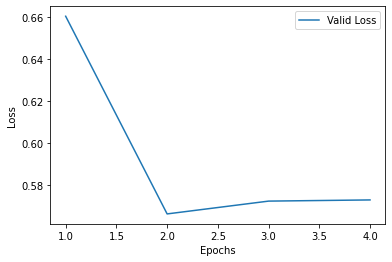

In [ ]:
loss_valid = history.history['val_loss']
epochs = range(1, len(loss_valid)+1)

plt.plot(epochs, loss_valid, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

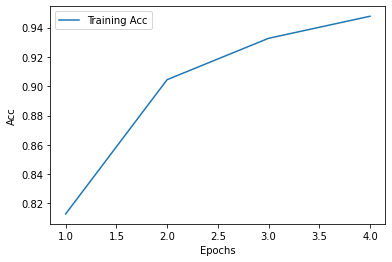

In [ ]:
acc_train = history.history['accuracy']
epochs = range(1, len(acc_train)+1)

plt.plot(epochs, acc_train, label='Training Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

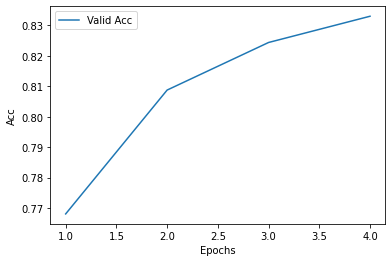

In [ ]:
acc_valid = history.history['val_accuracy']
epochs = range(1, len(acc_valid)+1)

plt.plot(epochs, acc_valid, label='Valid Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()